In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


0.5958716588846297


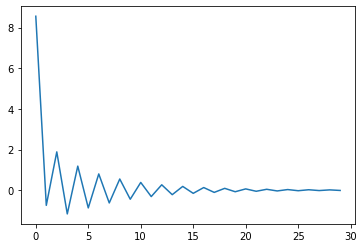

In [33]:
#let's set up the underlying system and parameters
np.random.seed(5)

A = np.random.normal(0,1,(5,5))
A = A + A.T 

A /=np.linalg.norm(A)

A*=1.05

# A+= .3*np.eye(5)

C = np.random.normal(0,4,(1,5))
B = np.random.normal(0,4,(5,1))

print(np.max(np.linalg.eigvals(A)))


#calculate the markov parameters

G = []

for i in range(30):
    G.append(C.dot(np.linalg.matrix_power(A,i).dot(B))[0][0])
    
plt.plot(G)

G= np.array(G)


In [136]:
#let's do the first experiment...

import matplotlib as mpl
dpi = 160
mpl.rcParams['figure.dpi']= dpi
mpl.rc("savefig", dpi=dpi)

def generate_data_correlated(c, g, sigma_e = .6):
    assert len(g) == 2
    
    if np.random.rand()>.5:
    
        u_0 = np.random.normal(0,1)+10
    else:
        u_0 = np.random.normal(0,1)-10
        
    u_1 = c*u_0 + np.random.normal(0,1)
    
    #make toeplitz matrix
    U = np.array([[u_0,0],[u_1,u_0]])
    
    #generate the debiasing output
    
    U_unbias = np.array([[-u_0,0],[u_1,-u_0]])
    
    #generate outputs
    
    y = U.dot(g) + np.random.normal(0,1,(2,))
    y_unbias = U_unbias.dot(g) + np.random.normal(0,1,(2,))
    
    return U,y,U_unbias,y_unbias

def runBias(c,g,n=400):
    for i in range(n):
        if i ==0:
            U,y,_,_ = generate_data_correlated(c, g)
        else:
            Unew,ynew,_,_= generate_data_correlated(c, g)
            U = np.append(U,Unew,axis = 0)
            y = np.append(y,ynew,axis = 0)
    
    ghat = (1/U[:,0].T.dot(U[:,0]))*(U[:,0].T.dot(y))
    
#     print(ghat)
    return ghat
        
        


def runUnBiased(c,g,n=200):
    for i in range(n):
        if i ==0:
            U,y,_,_ = generate_data_correlated(c, g)
        else:
            Unew,ynew,Uuncor,yuncor= generate_data_correlated(c, g)
            U = np.append(U,Unew,axis = 0)
            y = np.append(y,ynew,axis = 0)
            U = np.append(U,Uuncor,axis = 0)
            y = np.append(y,yuncor,axis = 0)
            
    
    
    ghat = (1/U[:,0].T.dot(U[:,0]))*(U[:,0].T.dot(y))
    
#     print(ghat)
    return ghat



def RunSimulation(c,g,numtrials = 1000):
    
    biasedData = []
    unbiasedData = []
    
    #obtain the biased data:
    for i in range(numtrials):
        ghat = runBias(c,g)
        error = g[0]-ghat
        biasedData.append(error)
        
    for i in range(numtrials):
        ghat = runUnBiased(c,g)
        error = g[0]-ghat
        unbiasedData.append(error)
    
    
    plt.figure()
#     plt.title()
    plt.xlabel('Error')
    plt.ylabel('Density')
    sns.kdeplot(biasedData,color = 'red',label = 'Biased Data')
    sns.kdeplot(unbiasedData,color = 'blue',label = 'Unbiased Data')
    plt.legend()
#     plt.savefig('DeBiasingPlot.png')
    plt.show()
    
    
# RunSimulation(c,g)



# ghat = runBias(c,g)


# print(ghat)

# assert False
    

    

  0%|          | 2/1000 [00:00<01:24, 11.87it/s]

0.14683935121482036
0.002877431193677704
21
[12  2 19  5 11 18  8 17  7  4 14 20 28 23  9 22 10 24 13  3  1]


100%|██████████| 1000/1000 [01:01<00:00, 16.25it/s]


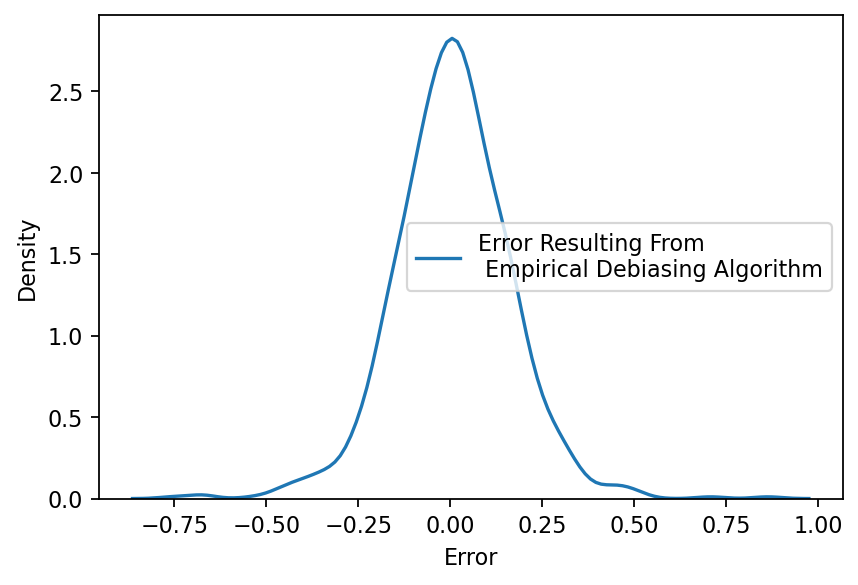

In [184]:
#okay so I need to write a function that minimizes bias

def generate_data_correlated2(c, g, sigma_e = .6):
    assert len(g) == 2
    
    
    u_0 = np.random.normal(0,1)
    if np.random.rand() > .5:
        u_1 = c*u_0 + np.random.normal(0,1)
    else:
        u_1 = -c*u_0 + np.random.normal(0,1)
    
    #make toeplitz matrix
    U = np.array([[u_0,0],[u_1,u_0]])
    
    #generate the debiasing output
    
    U_unbias = np.array([[-u_0,0],[u_1,-u_0]])
    
    #generate outputs
    
    y = U.dot(g) + np.random.normal(0,1,(2,))
    y_unbias = U_unbias.dot(g) + np.random.normal(0,1,(2,))
    
    return U,y,U_unbias,y_unbias





def CollectBiasData(c,g,n=400):
    for i in range(n):
        if i ==0:
            U,y,_,_ = generate_data_correlated2(c, g)
        else:
            Unew,ynew,_,_= generate_data_correlated2(c, g)
            U = np.append(U,Unew,axis = 0)
            y = np.append(y,ynew,axis = 0)
            
    return U,y


def calculateCost(U,S):
    
    #need to keep track of two sums
    invVal = 0
    biasVal = 0
    for s in S:
        Us = U[2*s:2*s+2,:]
        invVal += Us[0,:].dot(Us[0,:])
        biasVal += Us[0,:].dot(Us[1,:])
    
    return np.abs((1/invVal)*biasVal)
        
    
def minimizeEmpiricalBias(U,y,num_it = 5000):
    n= int(U.shape[0]/2)
    
    
    #need to define the minimization algorithm
    
    cost = np.inf
    
    optimalS = np.array([0])
    
    for i in range(num_it):
        Ssize = np.random.randint(5,n)
        S = np.random.choice(n,Ssize,replace = False)
        
        costval = calculateCost(U,S)
        
        if np.abs(costval) < cost:
            optimalS = S
            cost = np.abs(costval)
            
    #now I need to construct the optimal U and y to return the estimate
    
    for s in optimalS:
        if s ==optimalS[0]:
            Uopt = U[2*s:2*s+2,:]
            yopt = y[2*s:2*s+2]
        else:
            Uopt = np.append(Uopt,U[2*s:2*s+2,:],axis = 0)
            yopt = np.append(yopt,y[2*s:2*s+2],axis = 0)
            
    ghat = (1/(Uopt[:,0].T.dot(Uopt[:,0])))*(Uopt[:,0].T.dot(yopt))
            
    return optimalS, cost, Uopt, yopt,ghat



# U,y = CollectBiasData(c,g,n=50)

S = np.arange(20)

print(calculateCost(U,S))
            
optimalS,cost,Uopt,yopt,ghat = minimizeEmpiricalBias(U,y,num_it = 100)

print(cost)

print(len(optimalS))

print(optimalS)


numtrials = 1000

emperror = []

for i in tqdm(range(numtrials)):
    U,y = CollectBiasData(c,g,n=50)
    optimalS,cost,Uopt,yopt,ghat = minimizeEmpiricalBias(U,y,num_it = 500)
    error = g[0]-ghat
    emperror.append(error)

    
plt.figure()
#     plt.title()
plt.xlabel('Error')
plt.ylabel('Density')
sns.kdeplot(emperror,label = '')
plt.legend()
plt.title('Estimation Error Distribution Using \n Empirical Debiasing Algorithm')
plt.savefig('EmpiricalDeBiasDist.png',bbox_inches ='tight')
plt.show()

#let's calculate convergence again







# badcosts = []
# optcosts = []

# nsizes = np.arange(10,100,10)

# for ns in nsizes:
#     U,y = CollectBiasData(c,g,n=ns)
#     badcosts.append(calculateCost(U,np.arange(ns)))
#     optimalS,cost,Uopt,yopt,ghat = minimizeEmpiricalBias(U,y,num_it = 200)
#     optcosts.append(cost)

# plt.figure()
# plt.plot(nsizes, optcosts, 'b-s',label = 'Bias From Best Subset')
# plt.plot(nsizes, badcosts, 'r-s',label = 'Bias of \n Full Data')
# plt.legend()
# plt.xlabel('Data Set Size')
# plt.ylabel('Bias Magnitude')
# # plt.savefig('EmpiricalBiasMin.png')
# plt.show()
    





# print(calculateCost(U,S))



No handles with labels found to put in legend.


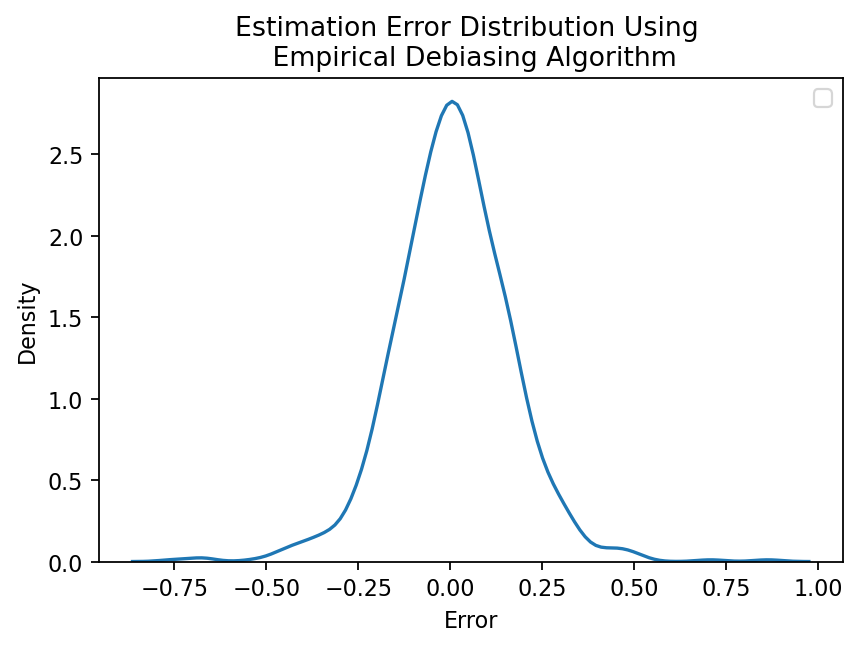

In [185]:
plt.figure()
#     plt.title()
plt.xlabel('Error')
plt.ylabel('Density')
sns.kdeplot(emperror,label = '')
plt.legend()
plt.title('Estimation Error Distribution Using \n Empirical Debiasing Algorithm')
plt.savefig('EmpiricalDeBiasDist.png',bbox_inches ='tight')
plt.show()

100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]


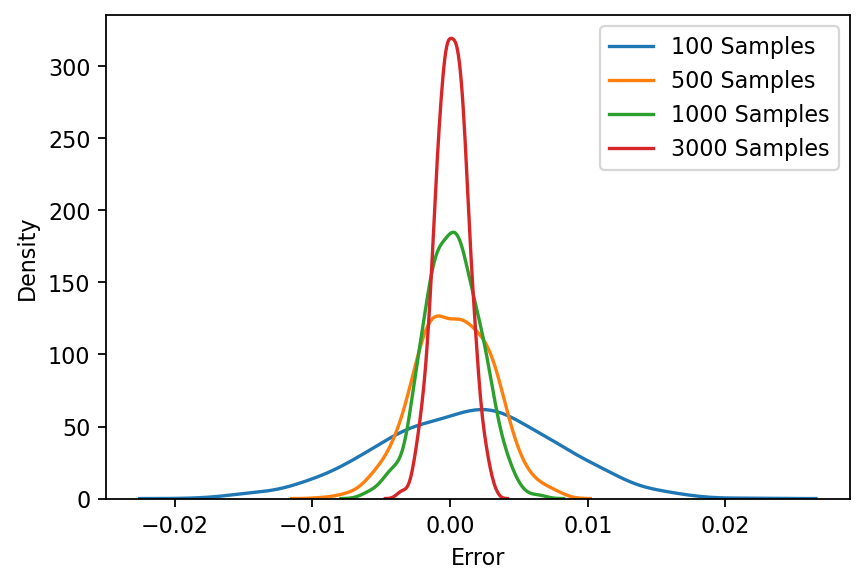

In [181]:
#need to run a new simulation to show that the method converges...

numtrials = 1000
    
unbiased100 = []
unbiased500 = []
unbiased1000 = []
unbiased3000 = []


for i in tqdm(range(numtrials)):
    ghat = runUnBiased(c,g,n=100)
    error = g[0]-ghat
    unbiased100.append(error)
    
for i in tqdm(range(numtrials)):
    ghat = runUnBiased(c,g,n=500)
    error = g[0]-ghat
    unbiased500.append(error)
    
for i in tqdm(range(numtrials)):
    ghat = runUnBiased(c,g,n=1000)
    error = g[0]-ghat
    unbiased1000.append(error)
    
for i in tqdm(range(numtrials)):
    ghat = runUnBiased(c,g,n=3000)
    error = g[0]-ghat
    unbiased3000.append(error)
    

plt.figure()
#     plt.title()
plt.xlabel('Error')
plt.ylabel('Density')
sns.kdeplot(unbiased100,label = '100 Samples')
sns.kdeplot(unbiased500,label = '500 Samples')
sns.kdeplot(unbiased1000,label = '1000 Samples')
sns.kdeplot(unbiased3000,label = '3000 Samples')
plt.legend()
plt.savefig('DeBiasConvergencePlot.png')
plt.show()

In [ ]:
# def generate_data_correlated(c, g, sigma_e = .6):
#     assert len(g) == 2
    
#     u_0 = np.random.normal(0,1)
#     u_1 = c*u_0 + np.random.normal(0,1)
    
#     #make toeplitz matrix
#     U = np.array([[u_0,0],[u_1,u_0]])
    
#     #generate the debiasing output
    
#     U_unbias = np.array([[-u_0,0],[u_1,-u_0]])
    
#     #generate outputs
    
#     y = U.dot(g) + np.random.normal(0,1,(2,))
#     y_unbias = U_unbias.dot(g) + np.random.normal(0,1,(2,))
    
#     return U,y,U_unbias,y_unbias

# def runBias(c,g,n=60):
#     for i in range(n):
#         if i ==0:
#             U,y,_,_ = generate_data_correlated(c, g)
#         else:
#             Unew,ynew,_,_= generate_data_correlated(c, g)
#             U = np.append(U,Unew,axis = 0)
#             y = np.append(y,ynew,axis = 0)
    
#     ghat = (1/U[:,0].T.dot(U[:,0]))*(U[:,0].T.dot(y))
    
# #     print(ghat)
#     return ghat


  4%|▍         | 19/500 [00:00<00:02, 188.43it/s]

[[ 0.25   0.375]
 [ 0.25  -0.125]]


100%|██████████| 500/500 [00:02<00:00, 245.90it/s]


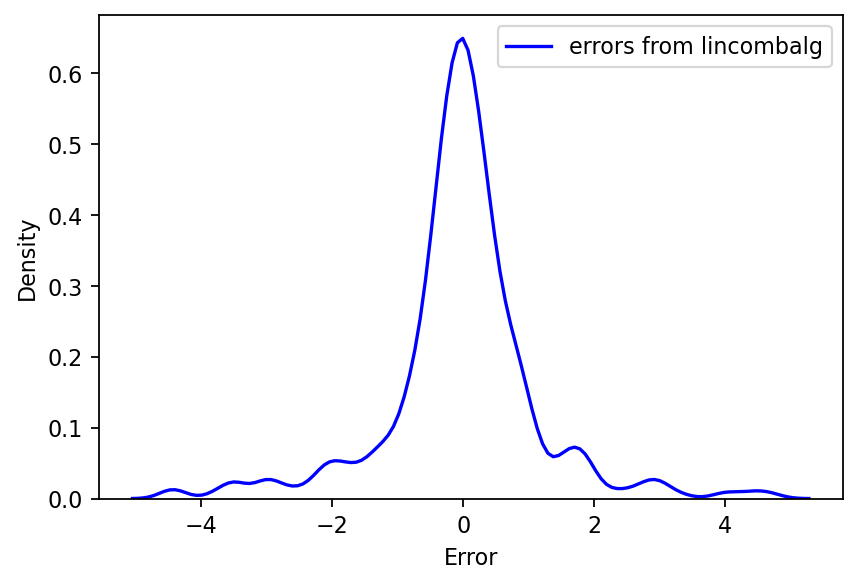

In [134]:
u = np.array([1,2])
v = np.array([3,-2])

umat = np.array([[1,0],[2,1]])
vmat = np.array([[3,0],[-2,3]])

uvmat = np.append(u.reshape((1,2)),v.reshape((1,2)),axis = 0).T

print(np.linalg.inv(uvmat))

.25*umat+.25*vmat


# okay so the above procedure gives the description of the algorithm that needs to be run...
def runLinCombAlg(c,g,n=100):
    for i in range(n):
        if i ==0:
            U,y,_,_ = generate_data_correlated(c, g,sigma_e = .1)
        else:
            Unew,ynew,_,_= generate_data_correlated(c, g,sigma_e = .1)
            U = np.append(U,Unew,axis = 0)
            y = np.append(y,ynew,axis = 0)
        
    
    for i in range(0,n*2,4):
        U1 = U[i:i+2,:]
        U2 = U[i+2:i+4,:]
        y1 = y[i:i+2]
        y2 = y[i+2:i+4]
        
        u1input = U1[:,0]
        u2input = U2[:,0]
        
        uvmat = np.append(u1input.reshape((1,2)),u2input.reshape((1,2)),axis = 0).T
        
        coeffs = np.linalg.inv(uvmat).dot(np.array([1,0]))
        
        if i == 0:
            Ulin = np.eye(2)
            ylin = coeffs[0]*y1 + coeffs[1]*y2
            
            
            
            
        else:
            Ulin = np.append(Ulin,np.eye(2),axis = 0)
            ylin = np.append(ylin,coeffs[0]*y1 + coeffs[1]*y2,axis = 0)
      
    
         
    ghat = (1/(Ulin[:,0].T.dot(Ulin[:,0])))*(Ulin[:,0].dot(ylin))
    
    return ghat

            
            
        
runLinCombAlg(c,g)
from tqdm import tqdm

def RunSimulation(c,g,numtrials = 500):
    
    errors = []
    
    #obtain the biased data:
    for i in tqdm(range(numtrials)):
        ghat = runLinCombAlg(c,g)
        error = g[0]-ghat
        if np.abs(error) >5:
            continue
        errors.append(error)
        
    
    
    
    plt.figure()
#     plt.title()
    plt.xlabel('Error')
    plt.ylabel('Density')
#     sns.kdeplot(biasedData,color = 'red',label = 'Biased Data')
    sns.kdeplot(errors,color = 'blue',label = 'errors from lincombalg')
#     plt.legend()
#     plt.savefig('DeBiasingPlot.png')
    plt.show()
    
RunSimulation(c,g)




In [145]:
np.random.choice(10,2,replace = False)

array([7, 6])

In [151]:
np.random.randint(1,100)

56